In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# import jax.numpy as jnp

from jax_canveg.subjects.utils import es as fes

# from jax_canveg.shared_utilities.forcings.get_forcing import get_modis_lai
# from jax_canveg.shared_utilities.forcings.get_forcing import get_modis_et

%load_ext autoreload
%autoreload 2

/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src/jax_canveg/shared_utilities/solver/fixed_point.py:69: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_jvp.defjvp` is deprecated in favour of `.def_jvp`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:, `None` was previously passed to indicate a symbolic zero tangent for all objects that weren't inexact arrays, but all inexact arrays always had an array-valued tangent. Now, `None` may also be passed to indicate that an inexact array has a symbolic zero tangent.
  def implicit_func_fixed_point_jvp(


In [2]:
site = "US-Whs"
dir_flux_data = Path(f"../../data/fluxtower/{site}")
dir_modis_data = Path(f"../../data/modis/{site}")

f_forcing = dir_flux_data / "AMF_US-Whs_FLUXNET_FULLSET_HH_2007-2020_3-5.csv"
f_modis_lai = dir_modis_data / "MCD15A3H" / "filtered_scaled_Lai_500m.csv"
f_modis_le = dir_modis_data / "MOD16A2GF" / "filtered_scaled_LE_500m.csv"

# modis_lai_scale_factor = 0.1
modis_lai_scale_factor = 1
modis_le_scale_factor = 1e4
pixel_ind = 144

# Start and end time
start, end = "2012-02-01", "2015-06-30"

# Flux tower data

In [3]:
# Read the dataframe
df = pd.read_csv(f_forcing)

In [4]:
# Get the time frame
df.index = pd.to_datetime(df["TIMESTAMP_END"], format="%Y%m%d%H%M")

In [5]:
# Vegetation height
df["veg_ht"] = 1.0

<Axes: xlabel='TIMESTAMP_END'>

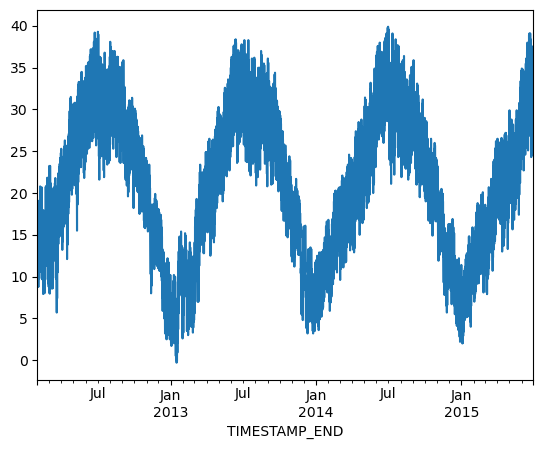

In [6]:
df[start:end]["TS_F_MDS_3"].plot()

/var/folders/b7/q6wyxw8x1_s5rh1mqvfb8vsr0000gn/T/ipykernel_7269/3894792412.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["RH"][df["RH"] == 0] = np.nan
/var/folders/b7/q6wyxw8x1_s5rh1mqvfb8vsr0000gn/T/ipykernel_7269/3894792412.py:4: 

<Axes: xlabel='TIMESTAMP_END'>

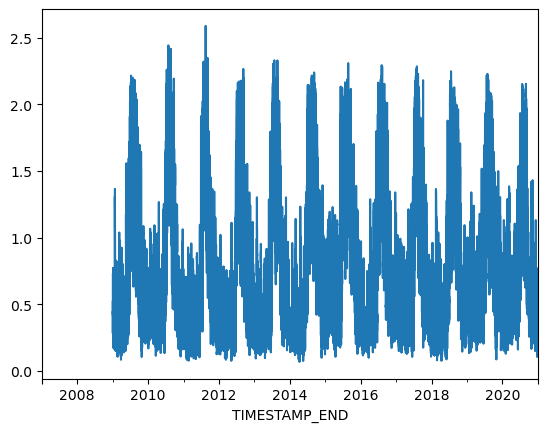

In [7]:
# Calculate vapor pressure from air temperature and relative humidity
es = fes(df["TA_F"].values + 273.15)
df["RH"] = np.clip(df["RH"], a_max=100, a_min=0)
df["RH"][df["RH"] == 0] = np.nan
ea = es * df["RH"].values / 100

df["eair"] = ea / 1e3  # convert from Pa to kPa
df["eair"].plot()

# MODIS data


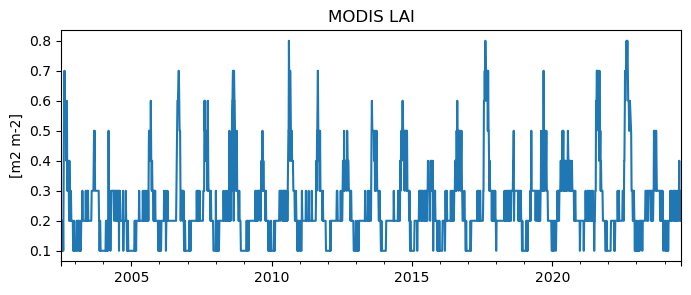

In [8]:
df_modis_lai = pd.read_csv(f_modis_lai, header=None)
df_modis_lai.index = df_modis_lai[2].apply(
    lambda x: pd.to_datetime(x[1:], format="%Y%j")
)
df_modis_lai["LAI"] = df_modis_lai[4 + pixel_ind].apply(
    lambda x: float(x) / modis_lai_scale_factor if x != "F" else np.nan
)
df_modis_lai = df_modis_lai[["LAI"]]
df_modis_lai = df_modis_lai.resample("30min").interpolate()
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
df_modis_lai["LAI"].plot(ax=ax)
ax.set(title="MODIS LAI", xlabel="", ylabel="[m2 m-2]");

<Axes: xlabel='2'>

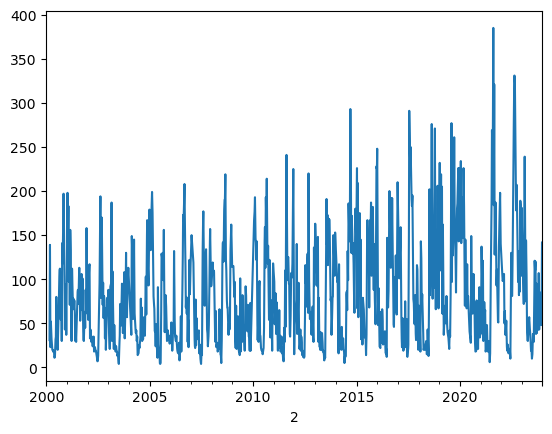

In [9]:
df_modis_le = pd.read_csv(f_modis_le, header=None)
df_modis_le.index = df_modis_le[2].apply(lambda x: pd.to_datetime(x[1:], format="%Y%j"))
df_modis_le["LE_MODIS"] = df_modis_le[4 + pixel_ind].apply(
    lambda x: float(x) / modis_le_scale_factor if x != "F" else np.nan
)
df_modis_le = df_modis_le[["LE_MODIS"]]
df_modis_le = df_modis_le.resample("30min").interpolate()
df_modis_le["LE_MODIS"].plot()

In [10]:
# df_modis = pd.concat([df_modis_lai, df_modis_le])
df_modis = df_modis_lai.join(df_modis_le)
df_modis.head()

,LAI,LE_MODIS
2,,
2002-07-04 00:00:00,0.2,12.000000
2002-07-04 00:30:00,0.2,12.083333
2002-07-04 01:00:00,0.2,12.166667
2002-07-04 01:30:00,0.2,12.250000
2002-07-04 02:00:00,0.2,12.333333


# Combine data

In [11]:
df = df.join(df_modis)
df = df[start:end]

# Forcings

In [12]:
df[df == -9999] = np.nan

In [13]:
df["Year"] = df.index.year
df["DoY"] = df.index.day_of_year
df["Hour"] = df.index.hour + df.index.minute / 60.0
df["SWC_F_MDS_1"] = df["SWC_F_MDS_1"] / 100.0

In [14]:
# The following information is needed to drive CanVeg
in_varns = [
    "Year",
    "DoY",
    "Hour",
    "TA_F",
    "SW_IN_F",
    "eair",
    "WS_F",
    "CO2_F_MDS",
    "PA_F",
    "USTAR",
    "TS_F_MDS_3",  # at depth of 15 cm
    "SWC_F_MDS_1",  # at depth of 5 cm
    "veg_ht",
    "LAI",
]

<Axes: xlabel='TIMESTAMP_END'>

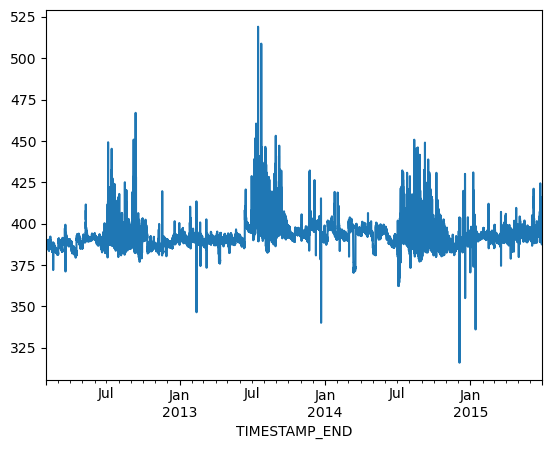

In [15]:
# Clean up the negative CO2 ppm
df.loc[df["CO2_F_MDS"] <= 100, "CO2_F_MDS"] = np.nan
df["CO2_F_MDS"].plot()

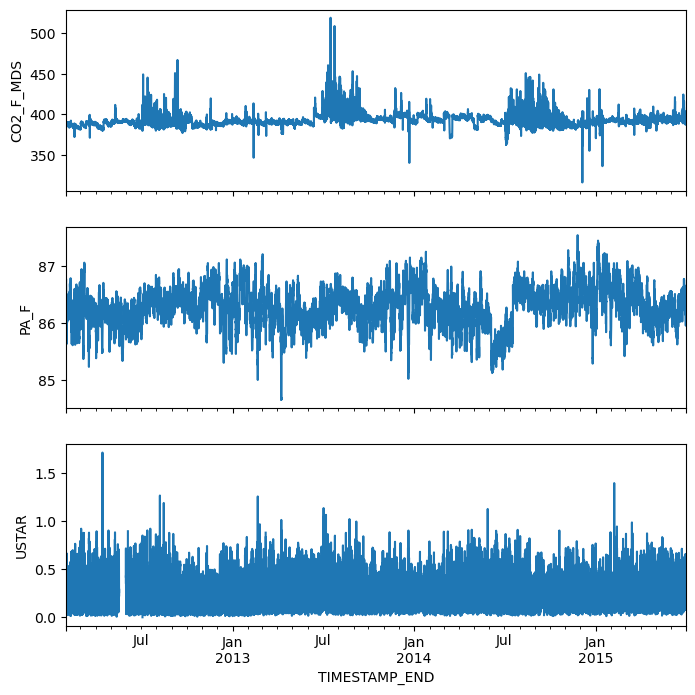

In [24]:
varns = ["CO2_F_MDS", "PA_F", "USTAR"]
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 8), sharex=True)
for i, varn in enumerate(varns):
    ax = axes[i]
    df[varn].plot(ax=ax)
    ax.set(ylabel=varn)

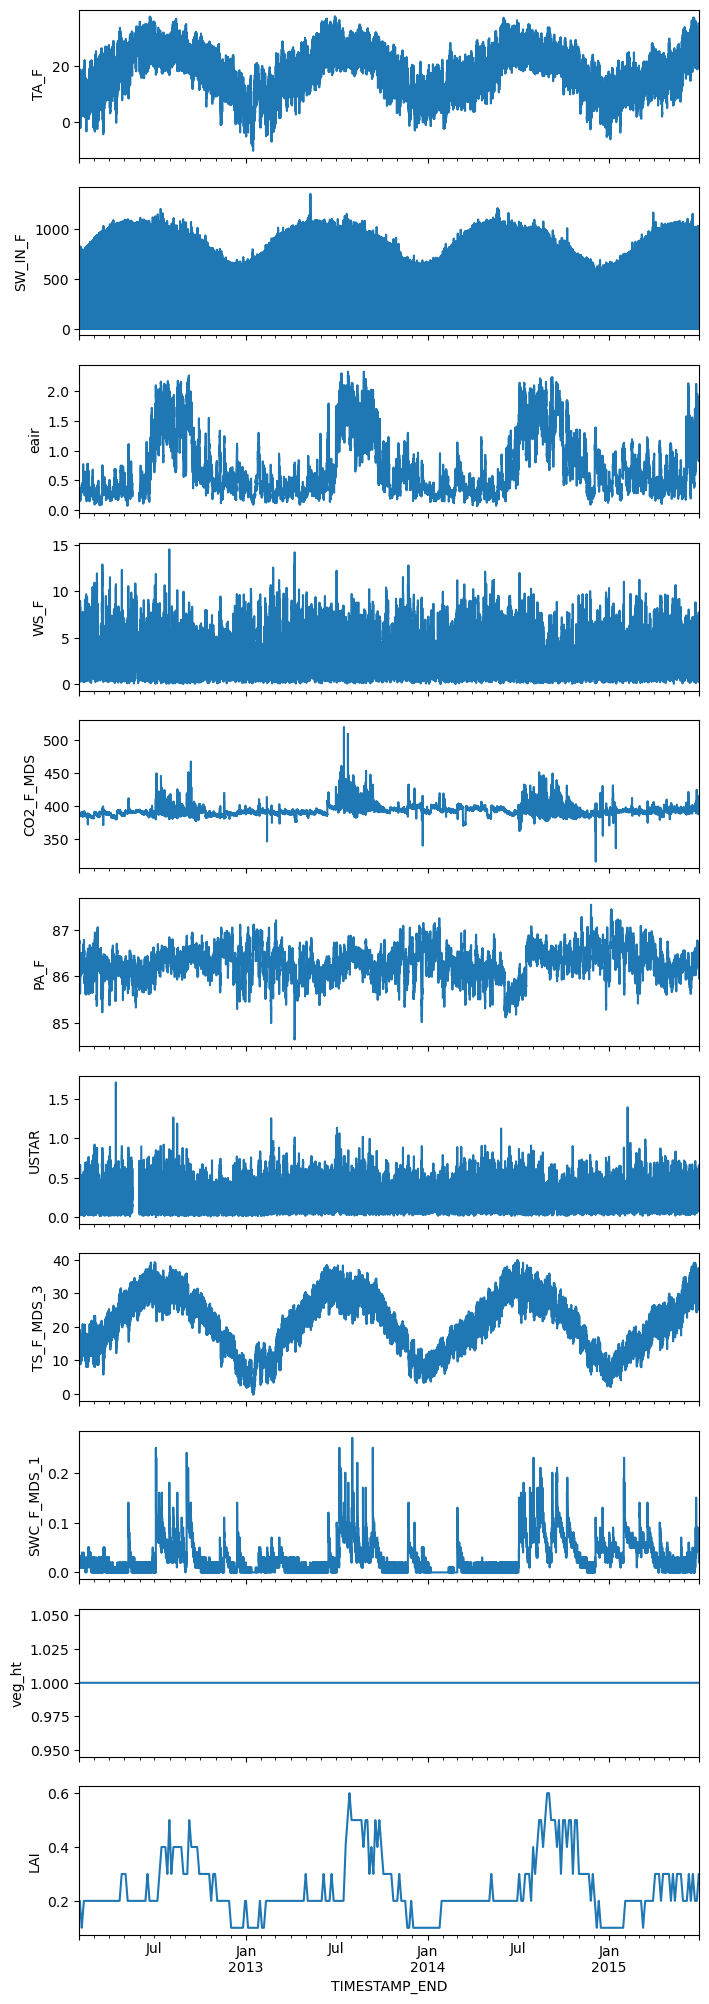

In [25]:
varns = in_varns[3:]
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 25), sharex=True)
for i, varn in enumerate(varns):
    ax = axes[i]
    df[varn].plot(ax=ax)
    ax.set(ylabel=varn)

In [16]:
df[in_varns][start:end]

,Year,DoY,Hour,TA_F,SW_IN_F,eair,WS_F,CO2_F_MDS,PA_F,USTAR,TS_F_MDS_3,SWC_F_MDS_1,veg_ht,LAI
TIMESTAMP_END,,,,,,,,,,,,,,
2012-02-01 00:00:00,2012,32,0.0,7.078,0.0,0.276210,1.805,385.610,86.730,0.0314,13.38,0.02000,1.0,0.175000
2012-02-01 00:30:00,2012,32,0.5,5.287,0.0,0.278478,3.027,385.627,86.741,0.1246,13.25,0.01898,1.0,0.175521
2012-02-01 01:00:00,2012,32,1.0,4.974,0.0,0.283438,2.764,385.167,86.754,0.0136,13.25,0.01859,1.0,0.176042
2012-02-01 01:30:00,2012,32,1.5,5.670,0.0,0.284254,3.272,385.104,86.750,0.0330,13.25,0.01888,1.0,0.176563
2012-02-01 02:00:00,2012,32,2.0,6.370,0.0,0.284819,2.989,385.032,86.739,0.0980,13.38,0.01918,1.0,0.177083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-06-30 21:30:00,2015,181,21.5,20.600,0.0,1.762196,3.353,390.410,86.469,0.2803,35.90,0.02000,1.0,0.277604
2015-06-30 22:00:00,2015,181,22.0,20.820,0.0,1.839413,2.941,391.498,86.490,0.1636,35.40,0.02000,1.0,0.277083
2015-06-30 22:30:00,2015,181,22.5,20.870,0.0,1.858703,1.132,392.414,86.519,0.2114,35.00,0.02000,1.0,0.276562


In [16]:
# Save the forcing data
start_train, end_train = "2012-02-01", "2014-06-30"
df_save = df[in_varns][start_train:end_train]
df_save.interpolate(inplace=True)
df_save.to_csv(dir_flux_data / "US-Whs-forcings.csv")
# np.savetxt(dir_flux_data / "US-Whs-forcings.csv", df_save.values, delimiter=",")

# Save the forcing data to be loaded in CanVeg-matlab
np.savetxt(dir_flux_data / "US-Whs-forcings.txt", df_save.values, delimiter=",")

In [17]:
# Save the forcing data -- test
start_test, end_test = "2014-07-01", "2015-06-30"
df_save = df[in_varns][start_test:end_test]
df_save.interpolate(inplace=True)
df_save.to_csv(dir_flux_data / "US-Whs-forcings-test.csv")

# Save the forcing data to be loaded in CanVeg-matlab
np.savetxt(dir_flux_data / "US-Whs-forcings-test.txt", df_save.values, delimiter=",")

# Responses/Fluxes

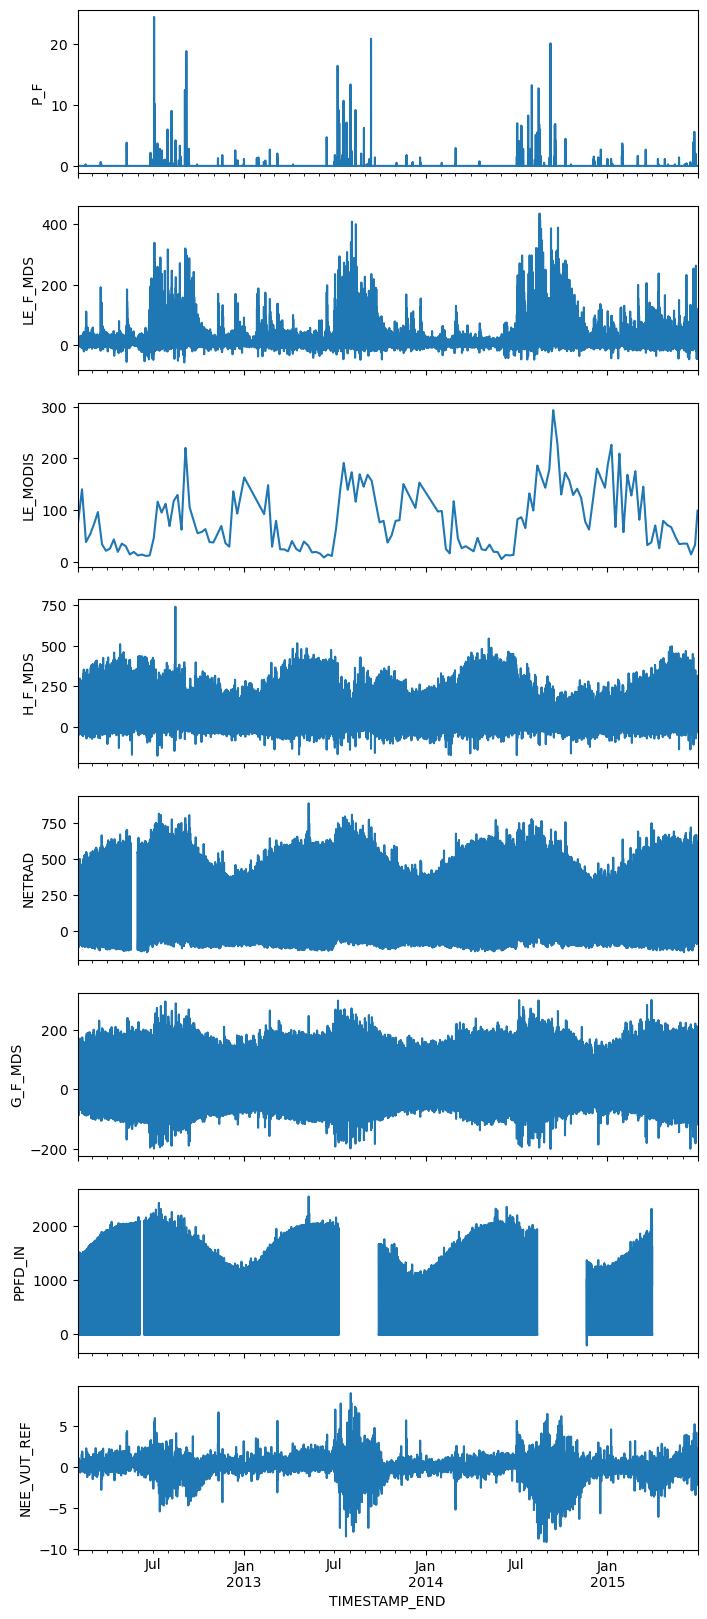

In [25]:
# The data to compare
out_varns = [
    "P_F",
    "LE_F_MDS",
    "LE_MODIS",
    "H_F_MDS",
    "NETRAD",
    "G_F_MDS",
    "PPFD_IN",
    "NEE_VUT_REF",
]
varns = out_varns
fig, axes = plt.subplots(len(varns), 1, figsize=(8, 20), sharex=True)
for i, varn in enumerate(varns):
    ax = axes[i]
    df[varn].plot(ax=ax)
    ax.set(ylabel=varn)

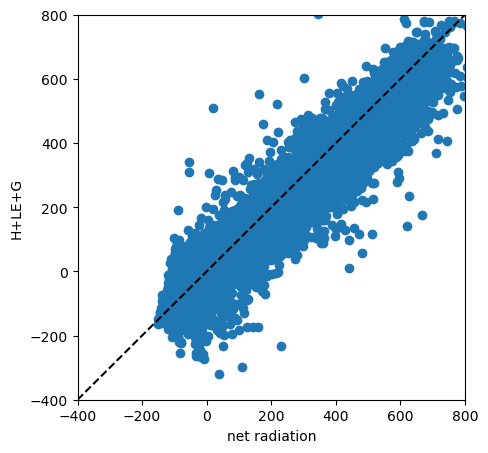

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
lim = [-400, 800]
ax.scatter(df["NETRAD"], df["H_F_MDS"] + df["LE_F_MDS"] + df["G_F_MDS"])
ax.plot(lim, lim, "k--")
ax.set(xlim=lim, ylim=lim, xlabel="net radiation", ylabel="H+LE+G");

In [28]:
# Save the data to compare
df_save = df[out_varns][start_train:end_train]
df_save.interpolate(inplace=True)
df_save.to_csv(dir_flux_data / "US-Whs-fluxes.csv", sep=",")

In [29]:
# Save the data to compare -- test
df_save = df[out_varns][start_test:end_test]
df_save.interpolate(inplace=True)
df_save.to_csv(dir_flux_data / "US-Whs-fluxes-test.csv", sep=",")